In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [2]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode
aa_idx = aa_encode.codes
aa_idx
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [3]:
with pm.Model(coords=aa_coords) as cs_fh_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_fh = pm.sample()

Output()

Output()

In [5]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 1, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)
    μ_nu = pm.Exponential('μ_nu', lam=1/30)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  nu = μ_nu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', nu = μ_nu, sigma = 10,
                      dims = "aa")

    ny = pm.StudentT('ny', mu = μ_mu, nu = μ_nu, sigma = μ_sd, dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  nu = ny[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


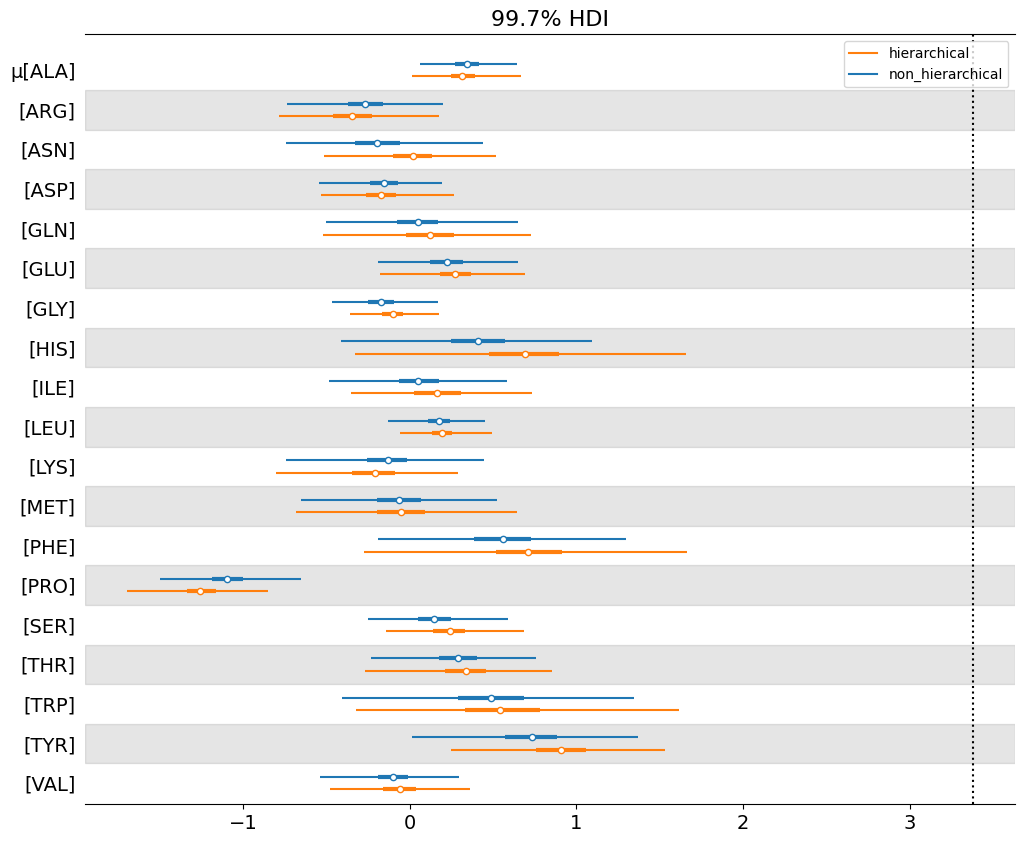

In [6]:
axes = az.plot_forest([idata_cs_fh, idata_cs_h], kind="forestplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

It's pretty close to the regular one, but as the original chem shifts get farther away from 0 the new model thinks it will be even farther. This means that the standard deviation is a lot bigger in the new model than the old one.

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

<Axes: xlabel='y'>

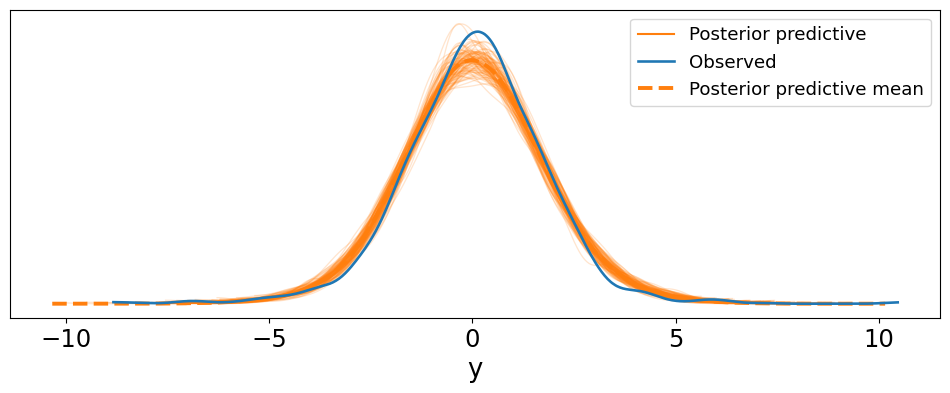

In [7]:
pm.sample_posterior_predictive(idata_cs_fh, model=cs_fh_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_fh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Output()

(-10.0, 10.0)

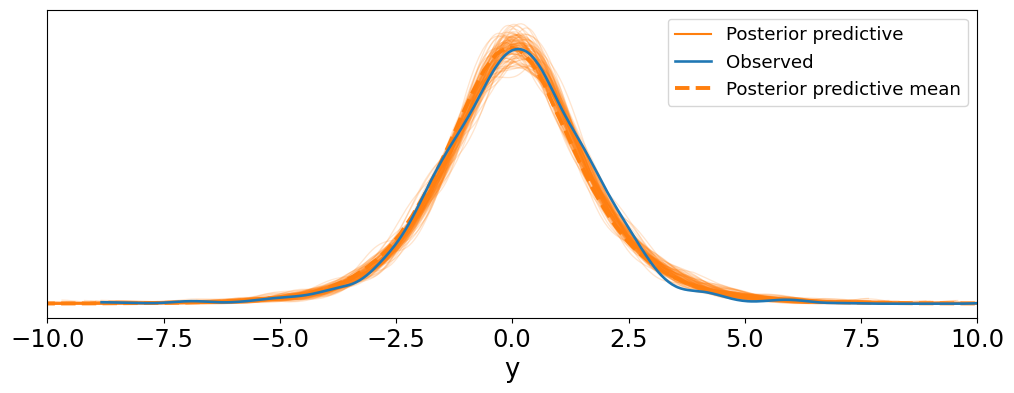

In [12]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(-10, 10)

The model that uses the StudentT priors seems to fit the data better

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [13]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [17]:
with pm.Model(coords = sccr_coords) as sccr_model:

    μ_p = pm.Beta('μ_p', alpha = 2, beta = 20, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.98)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.001 0.9996 1.002 ... 0.9998 1.0 1.0
    μ_p      (pos) float64 32B 1.002 1.002 1.076 1.001
    ν_p      (pos) float64 32B 1.01 1.002 1.106 1.018

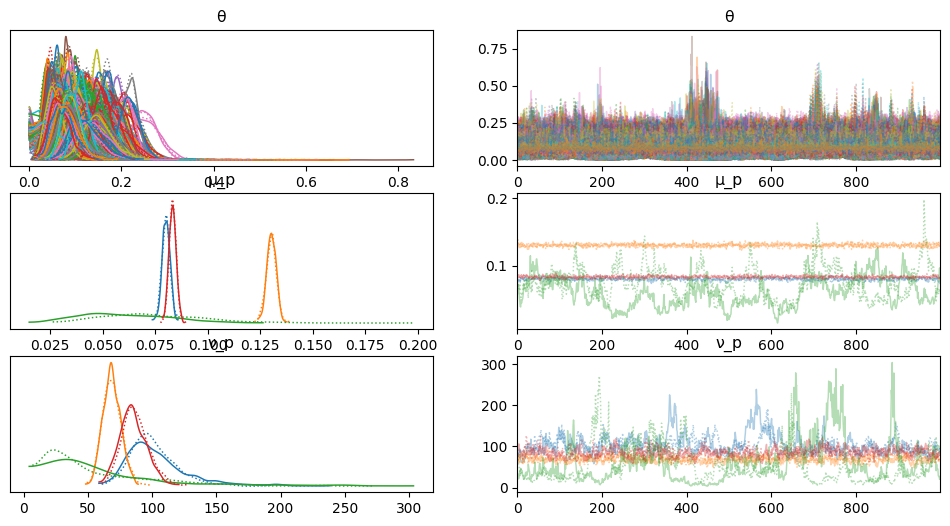

In [20]:
az.plot_trace(idata_sccr)
az.rhat(idata_sccr)

the v_p values are somewhat different and the 'GK' is the biggest difference. In the notes it says the value is 1.031 and in my model the value is 1.106. The graphs look somewhat the same. In the theta graph my model graphed the peaks on the other side of 400.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

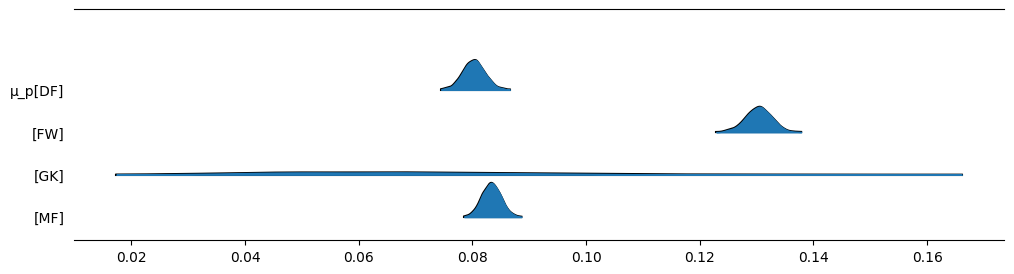

In [21]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The graphs are narrower and the peaks are higher which means that they are more certain the ones from the notes

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [22]:
sccr_data_noGK = sccr_data[sccr_data.position != 'GK'].copy()
sccr_data_noGK['position'] = pd.Categorical(sccr_data_noGK['position'])
sccr_data_noGK['position'] = sccr_data_noGK['position'].cat.remove_unused_categories()

In [23]:
pos_idx_noGK = sccr_data_noGK.position.cat.codes.values
pos_codes_noGK = sccr_data_noGK.position.cat.categories
sccr_coords_noGK = {"pos": pos_codes_noGK}

Index(['DF', 'FW', 'MF'], dtype='object')
{'pos': Index(['DF', 'FW', 'MF'], dtype='object')}


In [24]:
with pm.Model(coords = sccr_coords_noGK) as sccr_model_noGK:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_noGK], nu = ν_p[pos_idx_noGK])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_noGK.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_noGK.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_noGK = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 0.9995 1.0 1.005 1.003 ... 0.9999 1.001 1.0
    μ        float64 8B 1.001
    μ_p      (pos) float64 24B 1.003 1.004 1.001
    ν        float64 8B 1.003
    ν_p      (pos) float64 24B 1.006 1.005 1.006

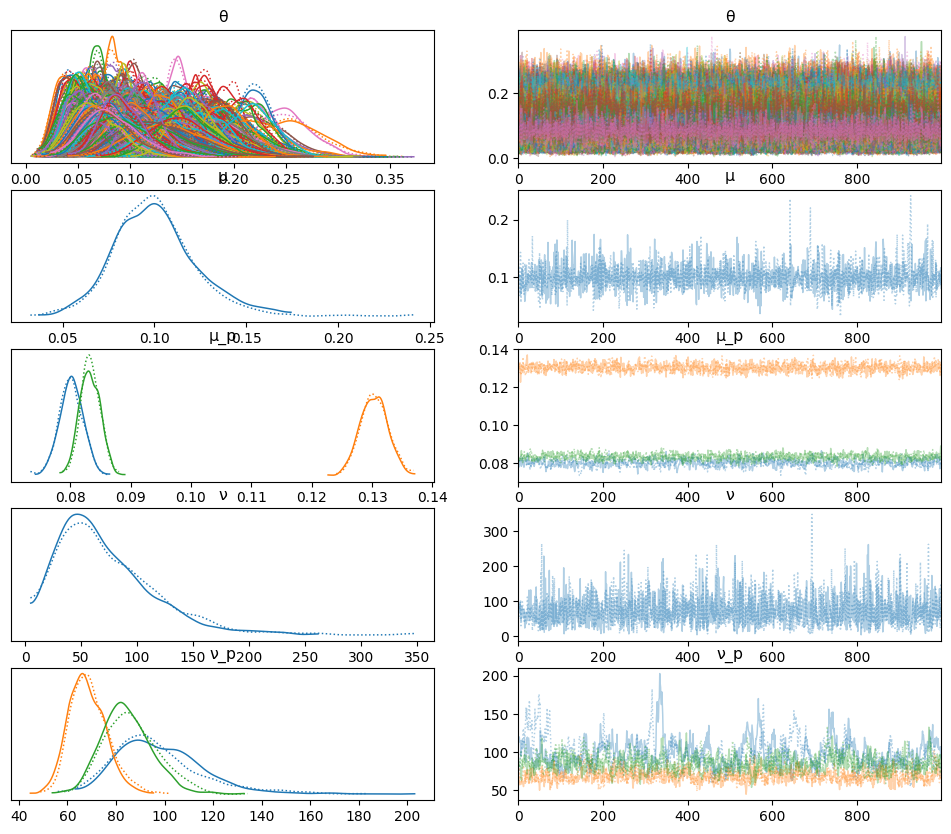

In [25]:
az.plot_trace(idata_sccr_noGK)
az.rhat(idata_sccr_noGK)

It was easier for pymc to do the model without GKs. This is because the GK data was so much different than every other position because the GK affects the game in a different way than the other positions. Without GKs we lose on of the positions of the game of soccer and are no longer analyzing a wide range of positions. However, we gain a more specific and cleaner analysis of the other positions that are more similar and exclude GKs which makes our model a little bit better and more efficient.